In [1]:
%load_ext autoreload
%autoreload 2

import os
import itertools
import utils
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt

from matplotlib import cm

In [2]:
print(os.getcwd())

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams["savefig.dpi"] = 140
plt.rcParams['text.usetex'] = True 

/home/manifold/Documents/pyprojects/mva-optimaltransport/project


# Room setup

We define a domain $\Omega$ and obstacles $\mathscr{O}$.

$\newcommand{\NN}{\mathbb N}$
$\newcommand{\RR}{\mathbb R}$
$\newcommand{\dif}{\mathrm{d}}$
$\renewcommand{\epsilon}{\varepsilon}$
$\renewcommand{\phi}{\varphi}$
$\newcommand{\suchthat}{\mathrm{s.t.}}$
$$
\DeclareMathOperator{\supp}{supp}
\DeclareMathOperator*{\argmin}{argmin}
\DeclareMathOperator*{\argmax}{argmax}
$$
$\newcommand{\bfR}{\mathbf R}$
$\newcommand{\bfP}{\mathbf P}$
$\DeclareMathOperator{\divg}{div}$
$\DeclareMathOperator{\supp}{supp}$
$\DeclareMathOperator{\KL}{KL}$
$\DeclareMathOperator{\prox}{prox}$

In [3]:
IMAGE_DIR = "images/"
os.makedirs(IMAGE_DIR, exist_ok=True)

In [4]:
nx = 181
xar = np.linspace(0, 1, nx)
xg, yg = np.meshgrid(xar, xar)

extent = [0, xar.max(), 0, 1]

In [5]:
from utils import plot_domain, plot_measure, send_zero_transparent
from utils.rooms import room1

In [6]:
# Obstacle domain
mask = room1(xg, yg)


obstacle_idx = np.argwhere(mask)

domain_img = np.zeros((nx, nx, 4))
domain_img[mask, 3] = 1.

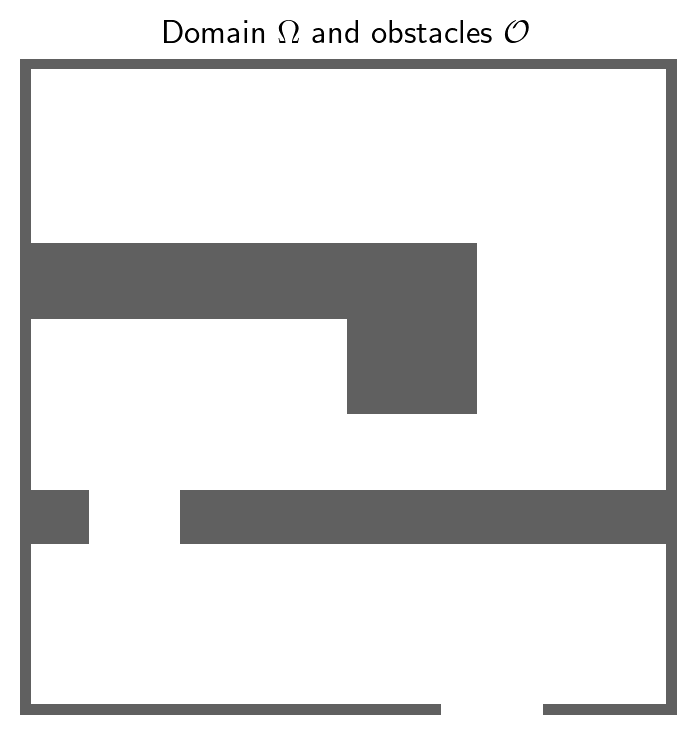

In [7]:
fig = plt.figure(figsize=(4,4))
plot_domain(domain_img)
plt.title("Domain $\\Omega$ and obstacles $\\mathcal{O}$")
plt.tight_layout()
plt.axis('off');

In [8]:
fig.savefig(IMAGE_DIR+"escape_domain.png", bbox_inches='tight')

# Standard two-measure transport problem

## Initial and target distributions

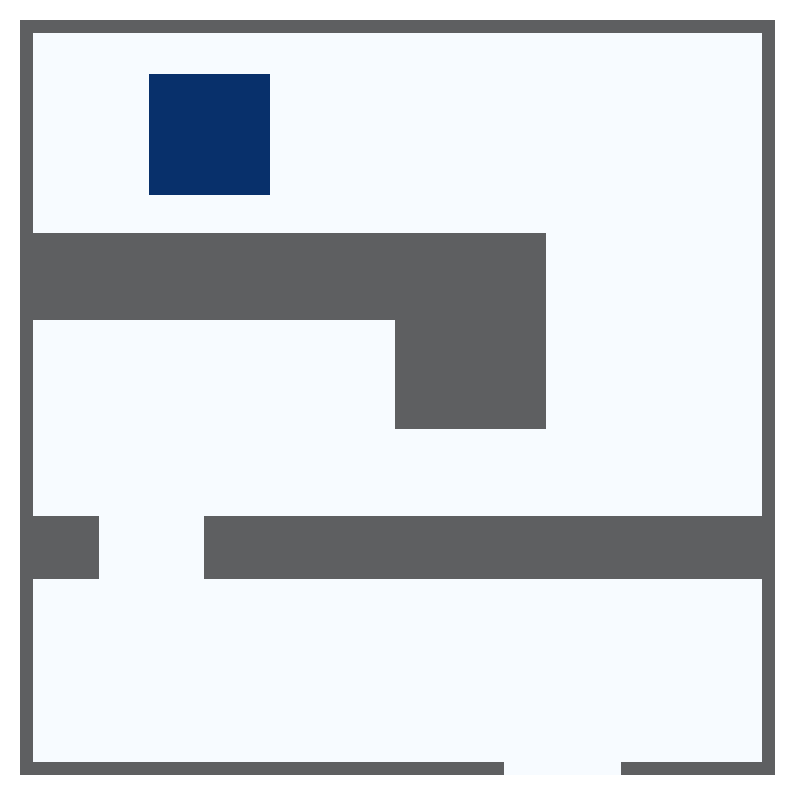

In [9]:
rho_0 = (np.abs(xg - 0.25) <= 0.08) & (np.abs(yg - 0.85) <= 0.08)
rho_0 = rho_0.astype(np.float64)
rho_0 /= rho_0.sum()  # normalize the density

fig, ax = plt.subplots()

plot_measure(rho_0, ax)
plot_domain(domain_img, ax)
plt.axis('off');

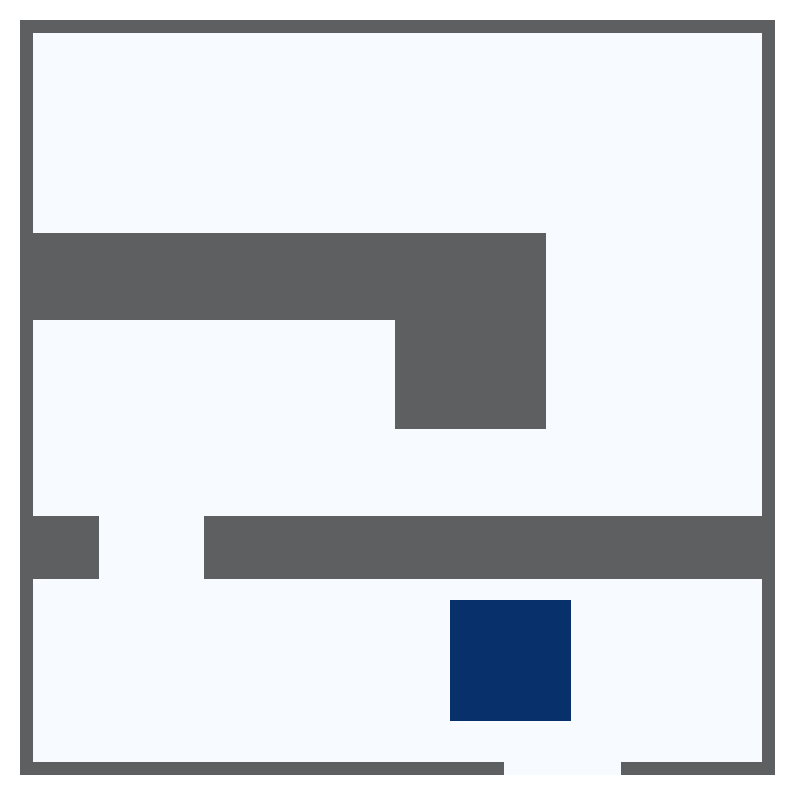

In [10]:
rho_tgt = (np.abs(xg - 0.65) <= 0.08) & (np.abs(yg - 0.15) <= 0.08)
rho_tgt = rho_tgt.astype(np.float64)
rho_tgt /= rho_tgt.sum()  # normalize the density

fig, ax = plt.subplots()

plot_measure(rho_tgt, ax);
plot_domain(domain_img, ax)
plt.axis('off');

## Problem setup

We first seek to minimize the following transport problem
$$
    \min_{\gamma} H(\gamma | R)
$$
subject to $\gamma_0 = P^0_\#\gamma = \rho_0$ and $\gamma_1 =P^1_\#\gamma = \rho_1$ (which is equivalent to penalizing with a function $G(\mu) = \imath_{\rho_1}(\mu)$).

The application $H$ is the Kullback-Leibler divergence
$$
    H(\alpha|\beta) = \sum_x\left(
    \alpha(x) \log\left(\frac{\alpha(x)}{\beta(x)}\right)
    - \alpha(x) + \beta(x)
    \right) =
    \left\langle \alpha, \log\frac\alpha\beta \right\rangle - \langle \alpha,\mathbf 1\rangle
    + \langle\beta, \mathbf 1\rangle
$$

$R = R_{0,1}$ is the marginal of the 2D Wiener measure at times $t=0,1$, which is given by the Gaussian kernel
$$
    R(x,y) = G_1(y_{0}-x_{0})G_1(y_{1}-x_{1})
$$
where $G_t \sim \mathcal N(0,t)$.

In [11]:
from scipy.stats import norm
from scipy.spatial import distance

Convolution with respect to this kernel can be computed fast.

In [12]:
# x-direction kernel
cost_mat1 = distance.cdist(xar[:, None],
                           xar[:, None])  # distance between 1st-coordinates
# Gaussian PDF applied element-wise
K1 = norm.pdf(cost_mat1)
K1.shape

(181, 181)

In [13]:
# Convolutioned kernel
K_kernel = lambda x: np.dot(K1 @ x, K1)

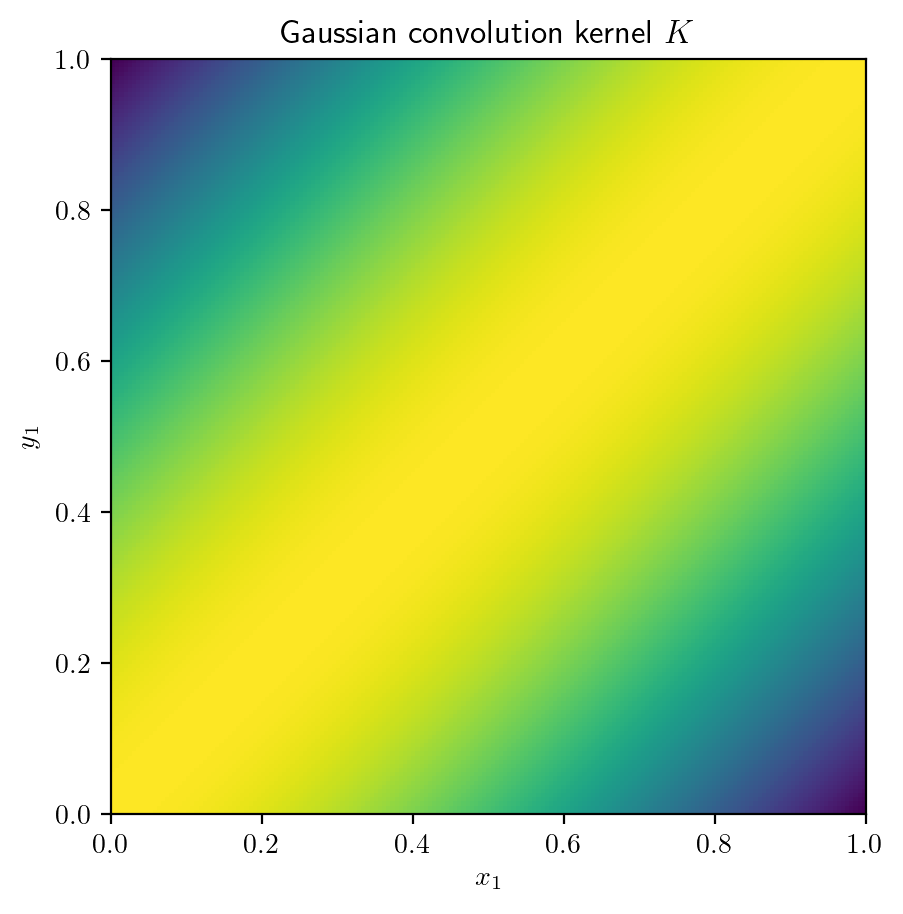

In [14]:
plt.imshow(K1, origin='lower', interpolation='none',
           extent=[0, xar.max(), 0, xar.max()])
plt.title("Gaussian convolution kernel $K$")
plt.xlabel("$x_1$")
plt.ylabel("$y_1$");

The appropriate iterative Bregman algorithm consists in KL-projecting the kernel $R$ alternatively on the constraints.

Which leads to the usual Sinkhorn iterations.

In [15]:
n_iter = 100

u0 = np.ones_like(rho_0)
u1 = np.ones_like(rho_tgt)

for n in range(n_iter):
    u0[:] = rho_0 / K_kernel(u1)
    u1[:] = rho_tgt / K_kernel(u0)

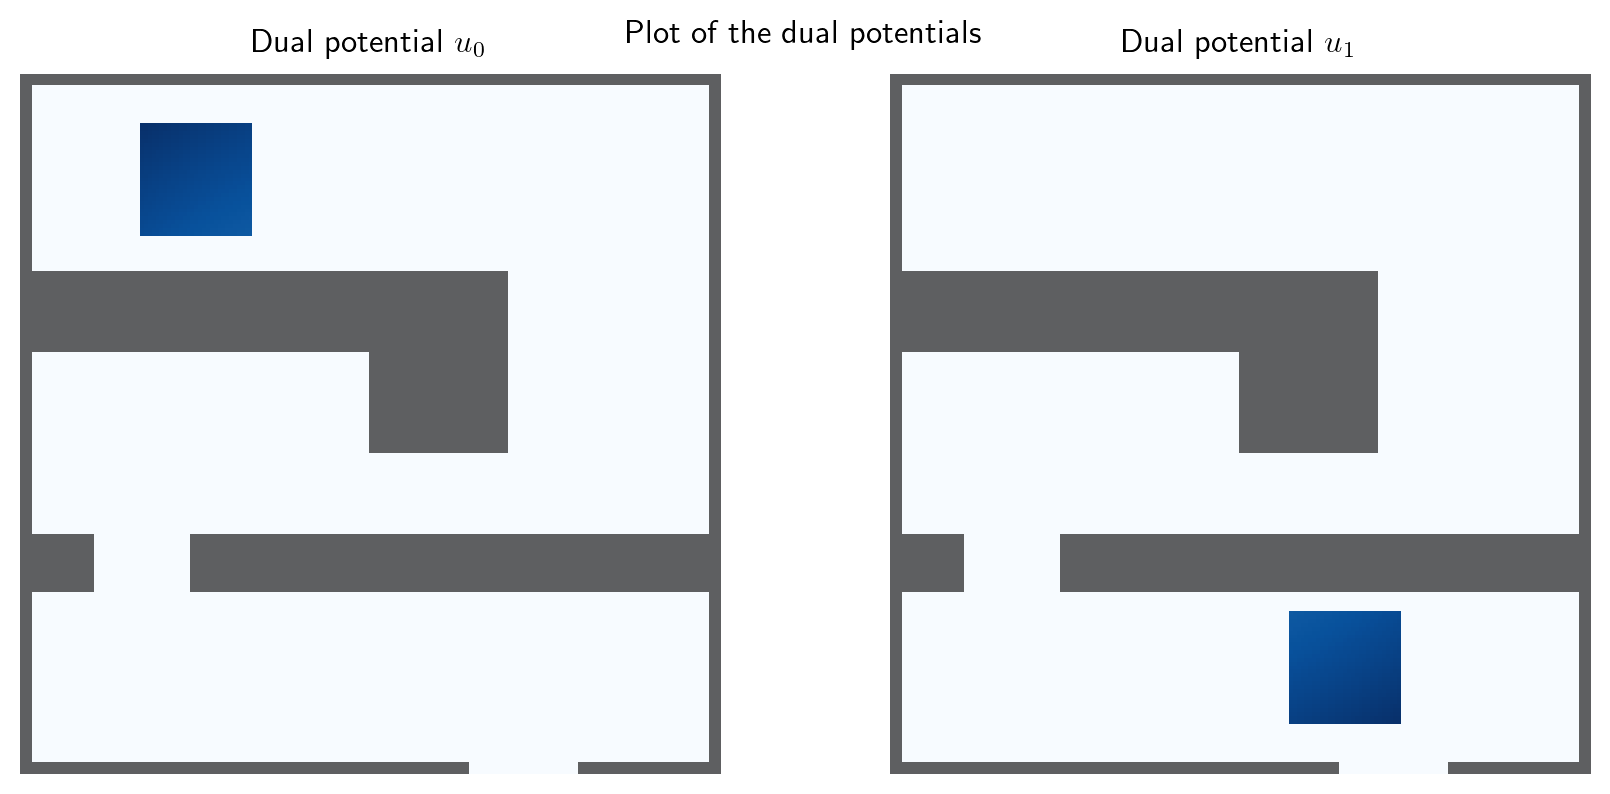

In [16]:
plt.figure(frameon=False, figsize=(9,4))
ax = plt.subplot(121)
plot_measure(u0, ax, cmap=cm.Blues)
plot_domain(domain_img, ax)
ax.set_title("Dual potential $u_0$")
plt.axis('off');

ax = plt.subplot(122)
plot_measure(u1, ax, cmap=cm.Blues)
plot_domain(domain_img, ax)
ax.set_title("Dual potential $u_1$")
plt.axis('off');
plt.suptitle("Plot of the dual potentials");
plt.tight_layout();

# Transport with fuzzy target

We start to move towards a mean-field control problem.

Given a marginal $\rho_0$, we now solve
$$
    \inf_\gamma H(\gamma | R) + G(P^1_\#\gamma)
$$
subject to $P^0_\#\gamma = \rho_0$, and with the penalty functional
$$
    G(\mu) = \int_\Omega \Psi(x)\,\dif\mu(x)
$$

We can use the potential $\Psi$ to target a desired distribution, as a relaxation of the former hard-constraint problem.

## Defining a potential $\Psi$

We take
$$
    \Psi(x) = d(x, \mathscr{A})^2
$$
where $\mathscr{A}$ is a set.

In [61]:
grid_arr_ = np.dstack([xg, yg])
grid_arr_flat = grid_arr_.reshape(nx*nx, 2)

In [62]:
target_mask = ((grid_arr_flat[:,0] >= 0.75) &
               (grid_arr_flat[:,0] <= 0.8) &
               (grid_arr_flat[:,1] >= 0.1) &
               (grid_arr_flat[:,1] <= 0.15))


target_points = grid_arr_flat[target_mask]

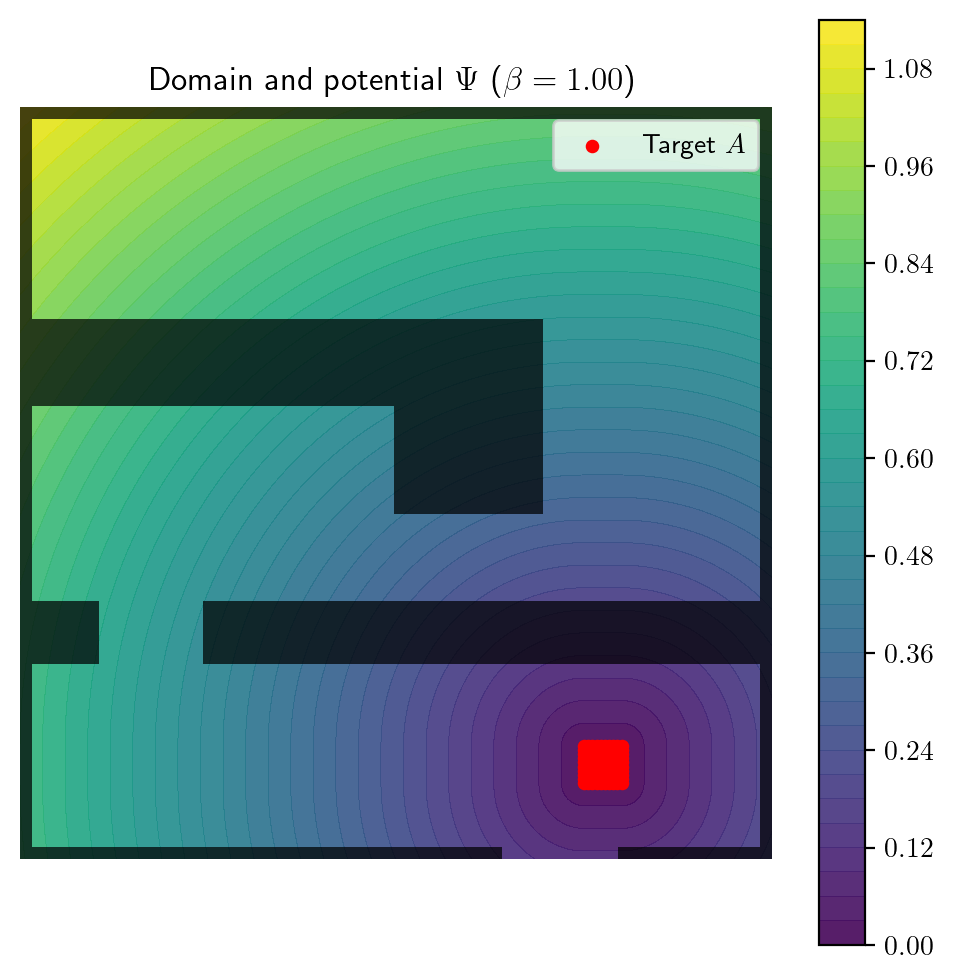

In [100]:
all_dists_ = distance.cdist(grid_arr_flat, target_points)

dist_to_target = all_dists_.min(axis=1)
dist_to_target = dist_to_target.reshape(nx, nx)

beta = 1
psi_potential_ = dist_to_target ** beta

fig, ax = plt.subplots()
cf_ = ax.contourf(xg, yg, psi_potential_, levels=40, alpha=.9)
fig.colorbar(cf_)

plot_domain(domain_img, ax)
plt.scatter(*target_points.T, s=15, label='Target $A$', c='r')
plt.legend()
plt.title("Domain and potential $\\Psi$ ($\\beta=%.2f$)" % beta);
plt.axis('off');

fig.tight_layout();

In [101]:
fig.savefig(IMAGE_DIR+"naive_potential.png", dpi='figure')

The discretized problem
$$
\begin{aligned}
    &\inf_\gamma H(\gamma|R) + \langle \Psi, \gamma^T\mathbf 1\rangle\\
    \text{s.t.}\ & \rho_0 = \gamma\mathbf 1
\end{aligned}
$$
can be shown to have a closed-form solution. Indeed, solving this convex problem leads to the following optimality condition:
$$
\begin{aligned}
    \gamma^* &= R \odot (e^{u_0^*} \otimes e^{-\Psi}) \\
    e^{u_0^*} &= \frac{\rho_0}{Re^{-\Psi}}
\end{aligned}
$$

Then, we get the final distribution $\rho_1$ as
$$
    \rho_1 = (\gamma^*)^T\mathbf 1
    = e^{-\Psi} \odot R e^{u_0^*}
$$

In [23]:
u0 = rho_0 / K_kernel(np.exp(-psi_potential_))
rho_final = np.exp(-psi_potential_) * (K_kernel(u0))

print("Total mass:", rho_final.sum())

# Check the Lagrange multiplier condition:
print("Mass is zero on mask:", np.allclose(rho_final * mask, 0))

Total mass: 0.9999999999999999
Mass is zero on mask: False


In [24]:
print("Amount on mass on mask:", np.sum(rho_final * mask))

Amount on mass on mask: 0.24330782508687937


So we see the total mass is still $1$, but that there is mass contained on the obstacles (which was previsible, we did nothing to prevent that).

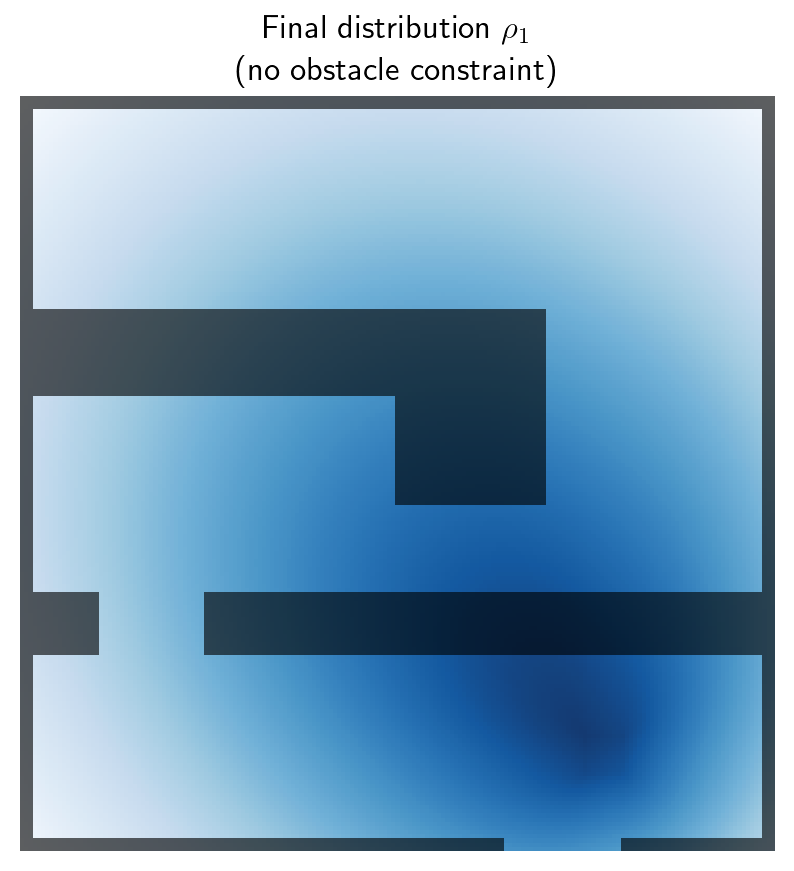

In [25]:
#fig = plt.figure(figsize=(9, 8), dpi=90)
fig = plt.figure()

alphm = 0.95
#plt.subplot(121)
#plot_measure(rho_0, alpha=alphm)
#plot_domain(domain_img)
#plt.title("Initial distribution $\\rho_0$")
#plt.axis('off');

#plt.subplot(122)
plot_measure(rho_final, alpha=alphm)
plot_domain(domain_img)
plt.title("Final distribution $\\rho_1$\n(no obstacle constraint)")
plt.axis('off');

In [26]:
fig.savefig(IMAGE_DIR+"fuzzy_transport_noobstacle.png", bbox_inches='tight')

## Adding the domain's obstacles

We can decompose the final distribution criterion $G$ as the sum of the potential $\Psi$ and a hard constraint:
$$
    G = G_1 + G_2
$$
with
$$
    \begin{aligned}
    G_1(\mu) &= \int_\Omega\Psi(x) \, \dif\mu(x) \\
    G_2(\mu) &= \int_\Omega V(x)\, \dif\mu(x)
    \end{aligned}
$$

Where $V$ is the indicatrix of the obstacles
$$
    V(x) = \begin{cases}
    +\infty &\text{ if } x\in\mathscr O \\
    0 &\text{ otherwise}
    \end{cases}
$$

We can see that $G_2$ is the convex indicator of the set of measures $\mu$ with support in $\Omega\backslash \mathscr O$.

The discretized problem is then
$$
\begin{aligned}
    &\inf_{\gamma,\rho_1} H(\gamma|R) + \langle \Psi, \rho_1 \rangle \\
    \text{s.t.}\ & \gamma \mathbf{1} = \rho_0  \\
    & \gamma^T\mathbf 1 = \rho_1   \\
    & \rho_1(x) = 0 \quad \forall x \in \mathscr O 
\end{aligned}
$$


Its dual is equivalent to
$$
    \sup_{u_0, \xi}~ q(u_0,\xi) = \left\langle R, \mathbf{1} - e^{-u_0\oplus (\Psi+\xi)}\right\rangle - \langle u_0,\rho_0\rangle
$$
where the Lagrange multiplier $\xi$ is supported in $\mathscr O$ (we set $\xi(y) = 0$ for $y \in \Omega\backslash\mathscr O$).

The optimum satisfies
$$
    e^{-u_0^*} = \frac{\rho_0}{R e^{-(\Psi + \xi^*)}}
$$
Writing the Euler condition leads to $\xi^*(y) = +\infty$ for all $y\in\mathscr O$, thus
$$
    e^{-u_0^*} = \frac{\rho_0}{R a_1^*}
$$
where $a_1^* = e^{-\Psi}\mathbf 1_{\Omega\backslash\mathscr O}$.

Then, the final distribution is given by
$$
    \rho_1 = \gamma^T\mathbf 1 = a_1^* \odot Re^{-u_0^*}
$$

In [27]:
## RECALL: mask is the indicatrix of obstacles
psi_hat = (1-mask) * np.exp(-psi_potential_)
u0 = rho_0 / K_kernel(psi_hat)  # potential u0

rho_final = K_kernel(u0) * psi_hat

print("Total mass:", rho_final.sum())

# Check the Lagrange multiplier condition:
print("Mass is zero on mask:", np.allclose(rho_final * mask, 0))

Total mass: 0.9999999999999999
Mass is zero on mask: True


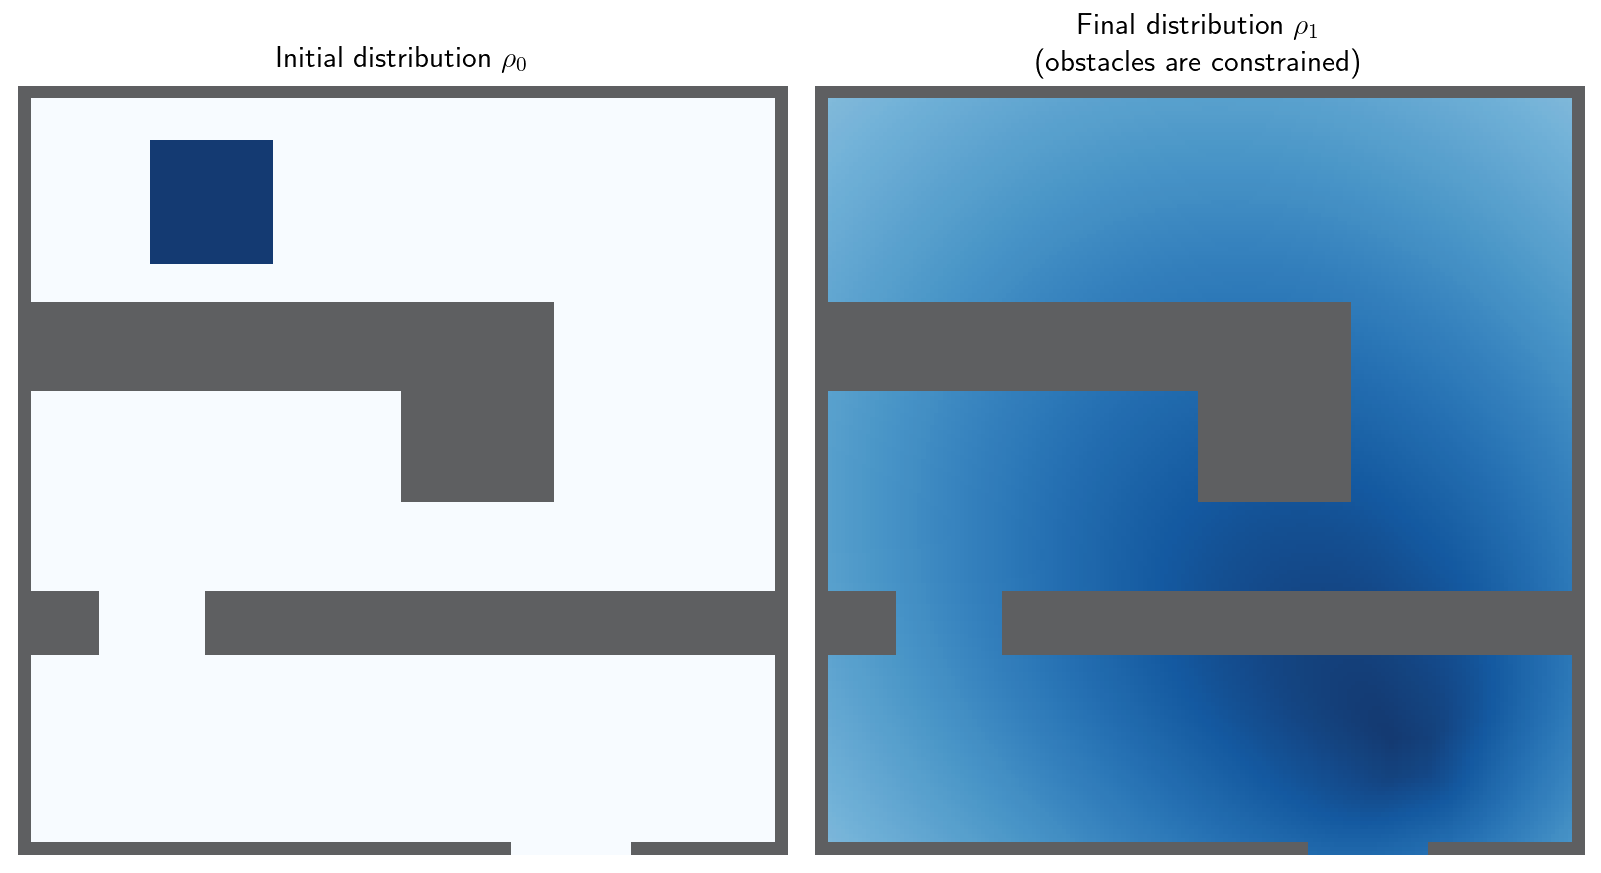

In [30]:
fig = plt.figure(figsize=(9, 8), dpi=90)

alphm = 0.95

plt.subplot(121)
plot_measure(rho_0, alpha=alphm)
plot_domain(domain_img)
plt.title("Initial distribution $\\rho_0$")
plt.axis('off')

plt.subplot(122)
plot_measure(rho_final, alpha=alphm)
plot_domain(domain_img)
plt.title("Final distribution $\\rho_1$\n(obstacles are constrained)")
plt.axis('off');

fig.tight_layout();

In [31]:
fig.savefig(IMAGE_DIR+"fuzzy_transport_withobstacle.png", bbox_inches='tight')

## Viscosity parameter

We now want to approximate the MFG problem
$$
\begin{align}
    -\partial_tu -\frac{\sigma^2}{2}\Delta u + \frac12|\nabla u|^2 &= f[\rho_t] \\
    \partial_t\rho - \frac{\sigma^2}{2}\Delta\rho - \divg(\rho\nabla u) &= 0\\
    \rho_0 \text{ given}& \\
    u(T, \cdot) = g[\rho_T]&
\end{align}
$$

We set $\epsilon = \sigma^2$. The MFG-OT problem is then given as
$$
\begin{aligned}
    &\inf_{\gamma,\rho_1} \epsilon H(\gamma | R_\epsilon) + G(\rho_1) \\
    \suchthat \ & P^1_\#\gamma = \rho_1
\end{aligned}
$$

In [32]:
sigma = 0.4
epsilon = sigma ** 2
print("Epsilon:", epsilon)
## New epsilon-kernel
K1_eps = norm.pdf(cost_mat1, scale=sigma)

K_eps_op = lambda x: np.dot(K1_eps @ x, K1_eps)

Epsilon: 0.16000000000000003


In [33]:
psi_hat = (1 - mask) * np.exp(-psi_potential_ / epsilon)

u0_eps = rho_0 / K_eps_op(psi_hat)

rho_final = psi_hat * K_eps_op(u0_eps)

print("Total final mass:", rho_final.sum())

Total final mass: 1.0


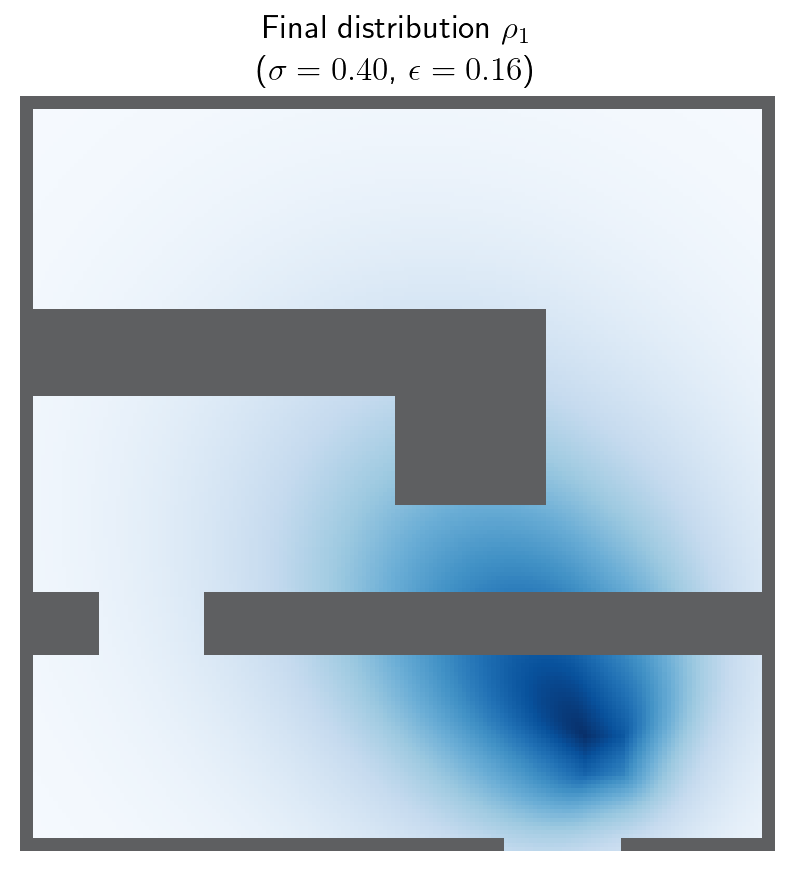

In [34]:
#fig = plt.figure(figsize=(9, 8), dpi=90)
fig = plt.figure()
"""plt.subplot(121)
plot_measure(rho_0)
plot_domain(domain_img)
plt.axis('off')
plt.title("Initial distribution $\\rho_0$")

plt.subplot(122)
"""
plot_measure(rho_final)
plot_domain(domain_img)
plt.title("Final distribution $\\rho_1$\n($\sigma=%.2f$, $\\epsilon=%.2f$)"
          % (sigma,epsilon))
plt.axis('off');

In [36]:
fig.savefig(IMAGE_DIR+"fuzzy_transport_lowvisc.png", bbox_inches='tight')

## "Smarter" potential function

We see from the previous examples that the 

We will use a new potential function $\Psi$ obtained by solving the Eikonal equation with a given target set $\Gamma$
$$
\begin{aligned}
    &|\nabla\Psi(x)|^2 = 1/f(x) \\
    &\Psi(x) = 0\ \text{ on }\Gamma
\end{aligned}
$$

We coded an efficient Fast Sweeping Method (FSM) (see [Zhao](#biblio)) in Cython to recover the appropriate distance for our domain topology.

In [70]:
from fastsweeper import fast_sweep

In [71]:
# Exit (target)
exit_mask = (np.abs(xg-0.8) < 0.06) & (np.abs(yg-0.1) < 0.06)

exit_layer = np.zeros((nx, nx, 4))
exit_layer[exit_mask, 0] = 1.
exit_layer[exit_mask, 3] = 1.

In [72]:
# Initialize the new distance array
speed_field = np.ones((nx, nx))
speed_field[mask] = 1e3  # "Kill" walking through the obstacles
dx = xar[1] - xar[0]
sweep_iters = 150

potential_new_ = fast_sweep(speed_field, dx, exit_mask, sweep_iters, init_value=6.)
beta = 1.
potential_new_ = potential_new_ ** beta

In [107]:
potential_new_[mask] = 20.

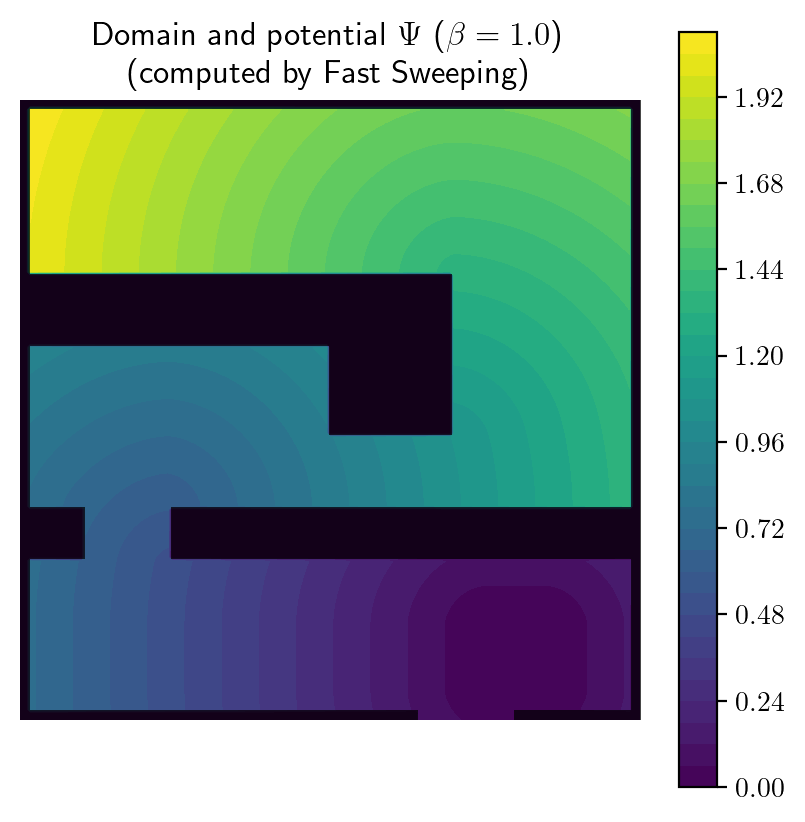

In [108]:
fig = plt.figure()
#im_ = plot_measure((1-mask) * potential_new_, alpha=alphm, cmap=cm.viridis)
plot_domain(domain_img, cmap=cm.binary)
im_ = plt.contourf((1-mask)*potential_new_, levels=40, extent=extent)
#plot_domain(exit_layer, alpha=.3)

plt.title("Domain and potential $\\Psi$ ($\\beta=%.1f$)\n(computed by Fast Sweeping)"
          % beta)
plt.colorbar(im_)
plt.axis('off');

In [109]:
fig.savefig(IMAGE_DIR+"crowd_eikonal_potential.png",
            dpi='figure', bbox_inches='tight')

In [110]:
## Define the kernel, its parameters, compute the dual potential
sigma = 0.4
epsilon = sigma ** 2
print("Epsilon:", epsilon)
## New epsilon-kernel
K1_eps = norm.pdf(cost_mat1, scale=sigma)

K_eps_op = lambda x: np.dot(K1_eps @ x, K1_eps)

# Dual potentials
u1_eps = (1 - mask) * np.exp(-potential_new_ / epsilon)
u0_eps = rho_0 / K_eps_op(u1_eps)

rho_final = u1_eps * K_eps_op(u0_eps)

print("Total final mass:", rho_final.sum())
print("Maximal density:", rho_final.max())

Epsilon: 0.16000000000000003
Total final mass: 0.9999999999999999
Maximal density: 0.0003596731104482514


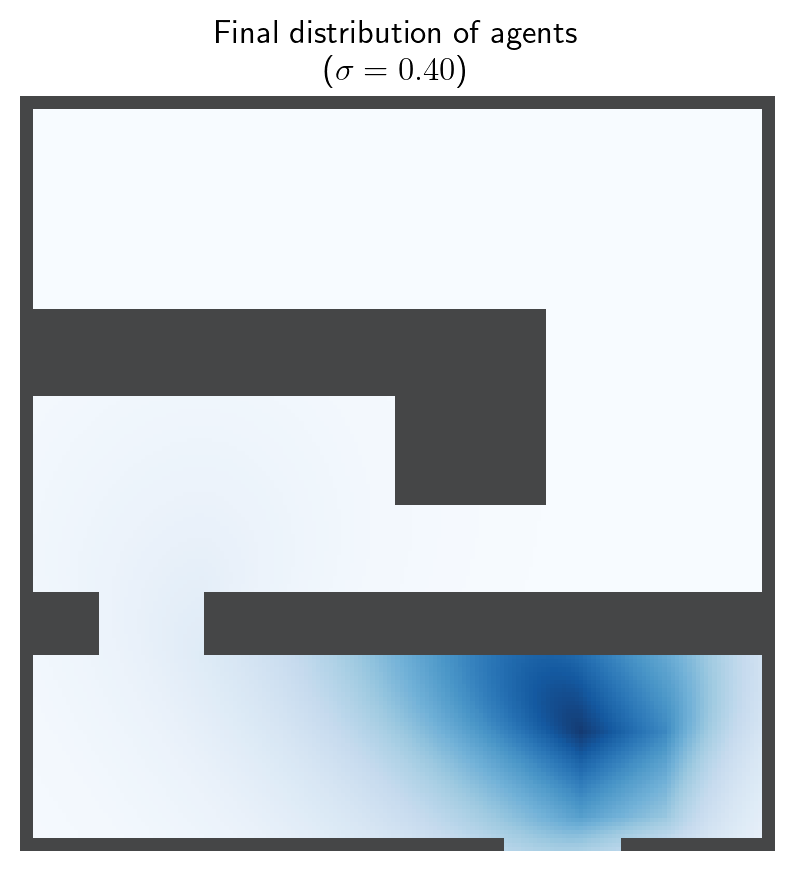

In [111]:
#fig = plt.figure(figsize=(9, 8), dpi=90)
fig = plt.figure()
alphm = .95

"""
plt.subplot(121)
plot_measure(rho_0, alpha=alphm)
plot_domain(domain_img)
plt.title("Initial distribution $\\rho_0$")
plt.axis('off');

plt.subplot(122)
"""
im_ = plot_measure(rho_final, alpha=alphm)
plot_domain(domain_img)
plt.title("Final distribution of agents\n($\\sigma=%.2f$)"
          % sigma)
plt.axis('off');

In [112]:
fig.savefig(IMAGE_DIR+"eikonal_transport_lowvisc.png",
            bbox_inches='tight')

# Three time steps

We formulate the problem as
$$
\begin{aligned}
    &\inf_{\gamma} \epsilon H(\gamma|R) + F(P^1_\#\gamma) + G(P^2_\#\gamma) \\
    \mathrm{s.t.}\ & P^0_\#\gamma = \rho_0
\end{aligned}
$$

The final penalty $G$ is given by the obstacle constraint, hard congestion and the potential $\Psi$:
$$
    G(\mu) = \langle \Psi, \mu\rangle +
    \imath_{\{\mu \leq \bar{m}\}} + \imath_0(\mathbf 1_{\mathscr O}\mu)
$$

We set $F$ to be both the hard congestion and obstacle constraint
$$
    F(\mu) = \imath_{\{\mu \leq \bar{m}\}} + \imath_0(\mathbf 1_{\mathscr O}\mu)
$$

In that case, the KL-proximal operator for $F$ is given by
$$
    \prox^{\KL}_F(\beta) = \min(\beta,
    \bar m \mathbf{1}_{\Omega\backslash\mathscr O})
$$

In [113]:
sigma = 0.4
epsilon = sigma ** 2
tmax = 1.
dt = tmax / 2.  # timestep is 0.5

print("Epsilon:", epsilon)
## New epsilon-kernel
K1_eps = norm.pdf(cost_mat1, scale=sigma * dt ** .5)

K_eps_op = lambda x: np.dot(K1_eps @ x, K1_eps)

Epsilon: 0.16000000000000003


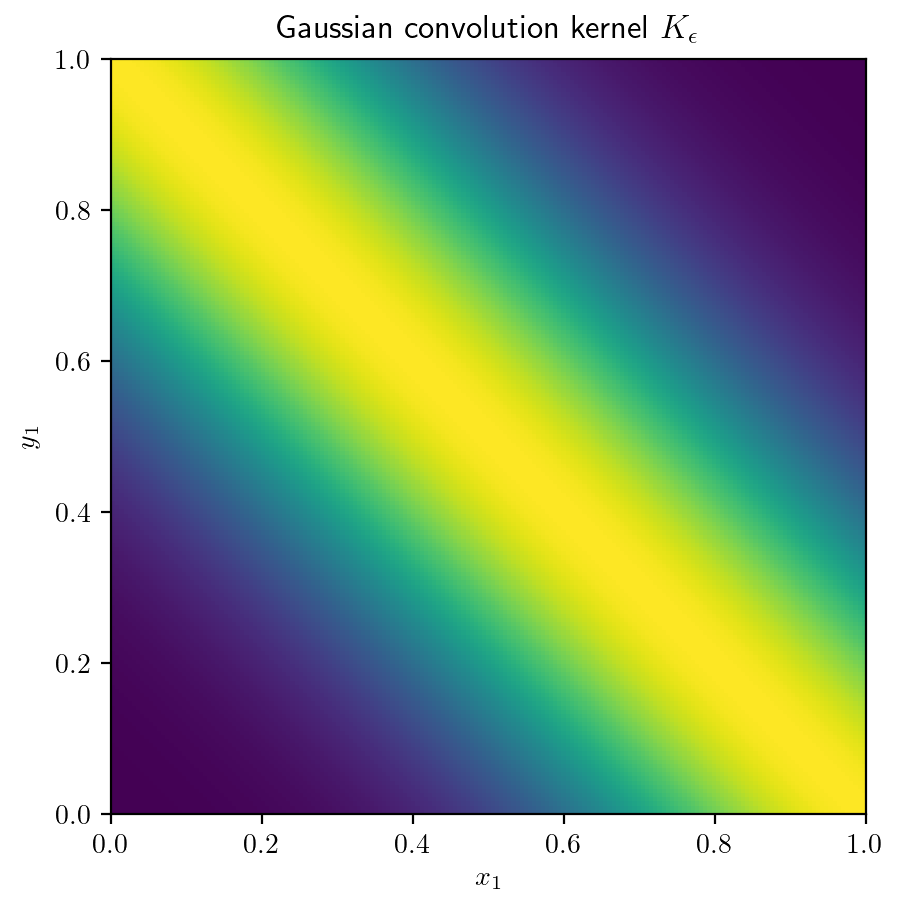

In [114]:
plt.imshow(K1_eps, interpolation='none', extent=[0,xar.max(),0,xar.max()])
plt.title("Gaussian convolution kernel $K_\\epsilon$")
plt.xlabel("$x_1$")
plt.ylabel("$y_1$");

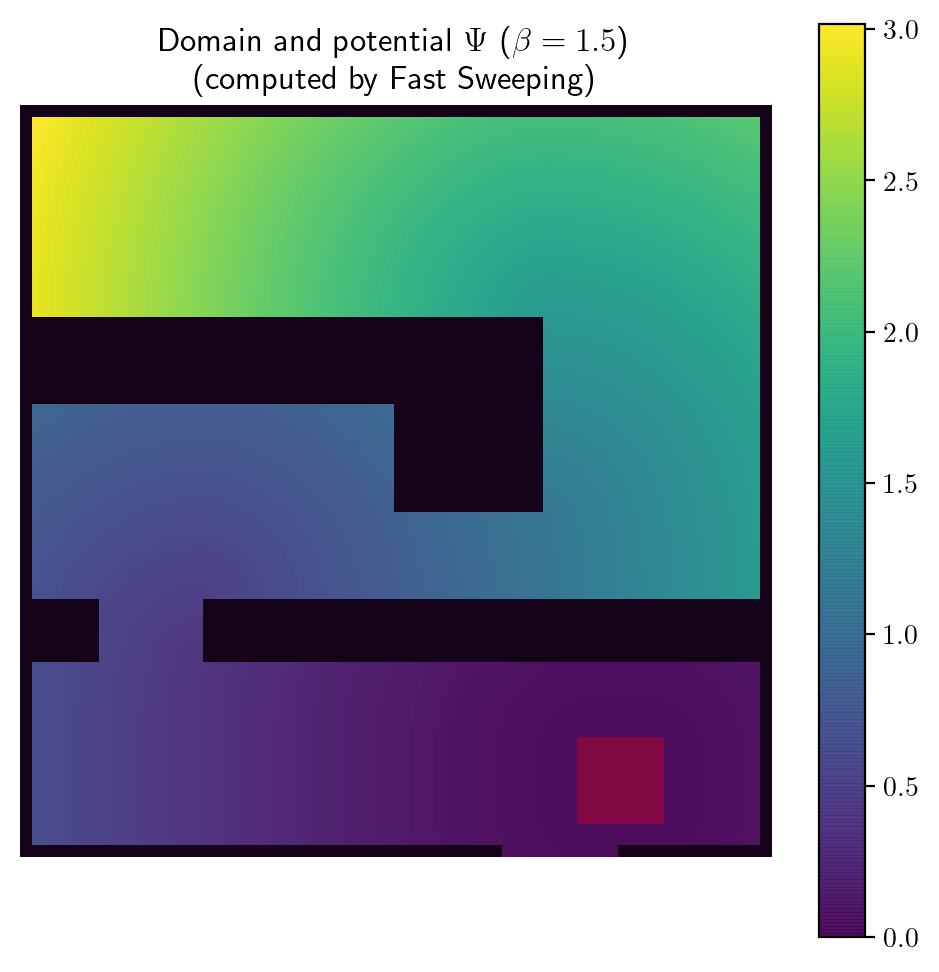

In [115]:
# Initialize the new distance array
speed_field = np.ones((nx,nx))
speed_field[mask] = 1e3  # "Kill" walking through the obstacles
dx = xar[1] - xar[0]
sweep_iters = 150

potential_new_ = fast_sweep(speed_field, dx, exit_mask, sweep_iters, init_value=100.)
beta = 1.5
potential_new_ = potential_new_ ** beta

fig = plt.figure()
im_ = plot_measure((1-mask) * potential_new_, alpha=alphm, cmap=cm.viridis)
plot_domain(domain_img)
plot_domain(exit_layer, alpha=.3)

plt.title("Domain and potential $\\Psi$ ($\\beta=%.1f$)\n(computed by Fast Sweeping)"
          % beta)
plt.colorbar(im_)
plt.axis('off');
fig.tight_layout();

In [116]:
# maximal congestion using previous final distrib
congest_max = 1.3 * rho_0.max()

def prox_operator(mes, mask, congest_max, psi):
    r"""Proximal operator"""
    return np.minimum(mes * np.exp(-psi/epsilon), congest_max) * (1-mask)

def three_sink_iterate(a0, a1, a2):
    """
    Perform one iteration of the three-way Sinkhorn.
    """
    conv0 = K_eps_op(K_eps_op(a2) * a1)
    a0 = rho_0 / conv0
    
    conv1 = K_eps_op(a0)*K_eps_op(a2)
    numer = prox_operator(conv1, mask, congest_max, 0.)
    a1 = numer / conv1
    
    conv2 = K_eps_op(a1 * K_eps_op(a0))
    numer = prox_operator(conv2, mask, congest_max, potential_new_)
    a2 = numer / conv2
    
    return a0, a1, a2
    

In [117]:
a_s = [
    np.ones((nx, nx)) for _ in range(3)
]
a0, a1, a2 = a_s

# Do Sinkhorn
num_iters = 10
for n in range(num_iters):
    a0[:], a1[:], a2[:] = three_sink_iterate(*a_s)

rho1 = a1 * K_eps_op(a0) * K_eps_op(a2)
rho2 = a2 * K_eps_op(a1 * K_eps_op(a0))

In [118]:
marginals = [
    rho_0,
    rho1,
    rho2
]

In [119]:
for mu in marginals:
    print(mu.sum())

1.0
1.0
0.9999999999999999


Text(0.5, 0.9, 'Discrete MFG. Three marginal case.\n$\\beta=1.500$, $\\sigma=0.400$')

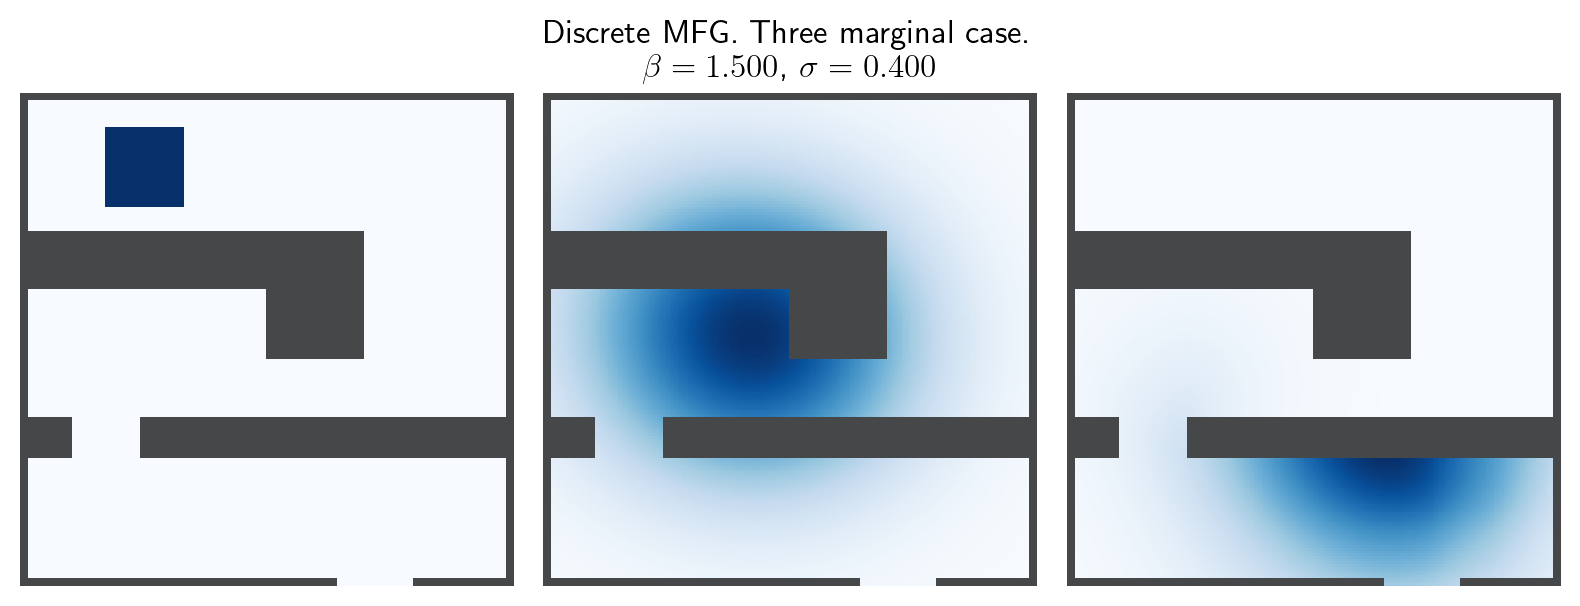

In [120]:
fig = plt.figure(figsize=(8, 4))

plt.subplot(131)
plot_measure(rho_0)
plot_domain(domain_img)
plt.axis('off')

plt.subplot(132)
plot_measure(rho1)
plot_domain(domain_img)
plt.axis('off')

plt.subplot(133)
plot_measure(rho2)
plot_domain(domain_img)
plt.axis('off')
plt.tight_layout();
plt.suptitle("Discrete MFG. Three marginal case.\n$\\beta=%.3f$, $\\sigma=%.3f$"
             % (beta, sigma), y=.9)

In [121]:
fig.savefig(IMAGE_DIR+"three_marginal_room1.png", bbox_inches='tight')

# Bibliography
<html><a name="biblio"></a></html>

1. [Zhao] Zhao, Hongkai. “A fast sweeping method for Eikonal equations.” Math. Comput. 74 (2004): 603-627.